In [6]:
import numpy as np
import pandas as pd
import pandas_profiling
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#from matplotlib import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

In [66]:
# import and clean test data

df = pd.read_pickle('pickle_copy.pkl')

In [67]:
df.dropna(subset=['CDR3', 'CONTROL'], inplace=True)
df = df.replace('PrivacySuppressed', np.NaN)
df.dropna(subset=['LO_INC_DEBT_N', 'MD_INC_DEBT_N', 'HI_INC_DEBT_N'], inplace=True)
df['Public_or_Private'] = df.CONTROL.map({2:0, 1:1, 3:1})

In [79]:
def create_logistic_regression(df, predictor_columns, predicted_column):
    """
    Creates a logistic regression from input column names to predictor column
    
    Parameters
    ----------
    df: pandas dataframe
        the dataframe's columns should include the predictor_columns and predicted_column
    
    predictor_columns: list
        Should be a subset of columns from df. 
        Should have empty intersection with predicted_column
    
    predicted_column: string
        Should be an element in the list of columns from df. 
        Should not be included in predictor_columns
        
    Returns
    -------
    logreg: logistic regression already trained on training data from predictor columns
    
    Note: This function will change the given dataframe
    """
    
    # Create dataframes( or series) with predictors and  predicted values
    X = df[predictor_columns]
    y = df[predicted_column]
    
    # Scale the data using Robust Scaler
    scale = RobustScaler()
    transformed = scale.fit_transform(X)
    X = pd.DataFrame(transformed, columns = X.columns)
    
    # Create Train and Test Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    
    # Create a logistic regression model
    logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='lbfgs')
    
    # Fit the model to the training data
    try:
        model_log = logreg.fit(X_train, y_train)
    except:
        model_log = logreg.fit(np.array(X_train).reshape(-1,1), y_train)
        
    # Add new columns to the given data frame with predicted values and probability of correct predictions
    try:
        df['Predicted_'+predicted_column] = logreg.predict(X)
        df['ProbCorrect_Predicted_'+predicted_column] = logreg.predict_proba(X)[:,1]
    except:
        df['Predicted_'+predicted_column] = logreg.predict(np.array(X).reshape(-1,1))
        df['ProbCorrect_Predicted_'+predicted_column] = logreg.predict_proba(np.array(X).reshape(-1,1))[:,1]
    
    return logreg

In [80]:
# Test create_logistic_regression

create_logistic_regression(df, ['CDR3', 'HI_INC_DEBT_N'], 'Public_or_Private'
                          ).score(df[['CDR3', 'HI_INC_DEBT_N']], df['Public_or_Private'])

0.7426352841647279

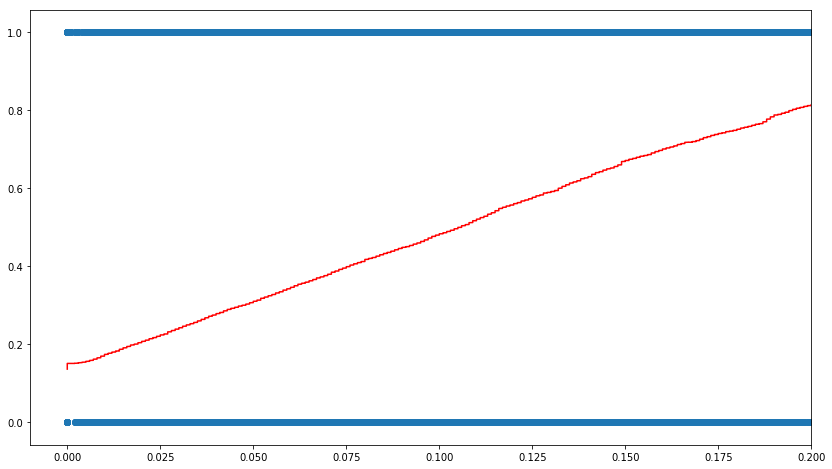

In [86]:
plt.figure(figsize=(14,8))
plt.scatter('CDR3', 'Public_or_Private', data=df)
plt.plot(df.CDR3.sort_values(), df.ProbCorrect_Predicted_Public_or_Private.sort_values(), c='r')
plt.xlim(-0.01,0.2)
plt.show()

In [64]:
def back_fill_from_year(df, year):
    fill_values = {np.NaN: np.NaN}
    for name in df.loc[df.year==year].INSTNM:
        fill_values[name] = {'LOCALE': df.loc[(df.INSTNM==name)&(df.year==year)].LOCALE, 
                             'CURROPER': df.loc[(df.INSTNM==name)&(df.year==year)].CURROPER}
    
#     for name in df.loc[df.year!=year].INSTNM:
#         if fill_values.get(name):
#             pass
#         else:
#             fill_values[name]={'LOCALE': np.NaN, 'CURROPER': np.NaN}
    
    df.LOCALE = df.INSTNM.map(fill_values, na_action='ignore')
    df.CURROPER = df.INSTNM.map(fill_values, na_action='ignore')
    
    return df

In [65]:
df_2016_and_2017 = back_fill_from_year(df.loc[(df.year==2017)|(df.year==2016)], 2017)

C:\Users\cliff\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154228 entries, 0 to 7057
Data columns (total 14 columns):
INSTNM           154228 non-null object
HIGHDEG          154228 non-null int64
CONTROL          154205 non-null float64
REGION           154227 non-null float64
LOCALE           6614 non-null float64
CURROPER         7058 non-null float64
TUITFTE          133780 non-null float64
INEXPFTE         133775 non-null float64
CDR3             47815 non-null float64
LO_INC_DEBT_N    137486 non-null object
MD_INC_DEBT_N    137486 non-null object
HI_INC_DEBT_N    137486 non-null object
ICLEVEL          154205 non-null float64
year             154228 non-null int64
dtypes: float64(8), int64(2), object(4)
memory usage: 17.6+ MB


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154228 entries, 0 to 7057
Data columns (total 14 columns):
INSTNM           154228 non-null object
HIGHDEG          154228 non-null int64
CONTROL          154205 non-null float64
REGION           154228 non-null float64
LOCALE           121893 non-null object
CURROPER         121893 non-null object
TUITFTE          133780 non-null float64
INEXPFTE         133775 non-null float64
CDR3             47815 non-null float64
LO_INC_DEBT_N    137486 non-null object
MD_INC_DEBT_N    137486 non-null object
HI_INC_DEBT_N    137486 non-null object
ICLEVEL          154205 non-null float64
year             154228 non-null int64
dtypes: float64(6), int64(2), object(6)
memory usage: 22.6+ MB


In [62]:
df.head()

,INSTNM,HIGHDEG,CONTROL,REGION,LOCALE,CURROPER,TUITFTE,INEXPFTE,CDR3,LO_INC_DEBT_N,MD_INC_DEBT_N,HI_INC_DEBT_N,ICLEVEL,year
0,Community College of the Air Force,2,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1996
1,Alabama A & M University,4,1.0,5.0,"0 12.0 Name: LOCALE, dtype: float64","0 1.0 Name: CURROPER, dtype: float64",NaN,NaN,NaN,NaN,NaN,NaN,1.0,1996
2,University of Alabama at Birmingham,4,1.0,5.0,"1 12.0 Name: LOCALE, dtype: float64","1 1.0 Name: CURROPER, dtype: float64",NaN,NaN,NaN,NaN,NaN,NaN,1.0,1996
3,ALABAMA AVIATION AND TECHNICAL COLLEGE,2,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1996
4,Amridge University,4,2.0,5.0,"2 12.0 Name: LOCALE, dtype: float64","2 1.0 Name: CURROPER, dtype: float64",NaN,NaN,NaN,NaN,NaN,NaN,1.0,1996


In [59]:
df.at[7655,'REGION'] = 5